# Seps Tutorial: Objects in the image

## Importing Libraries

In [12]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from matplotlib import rcParams
import astropy.io.fits as fitsio

In [13]:
%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

## Reading and displaying the image

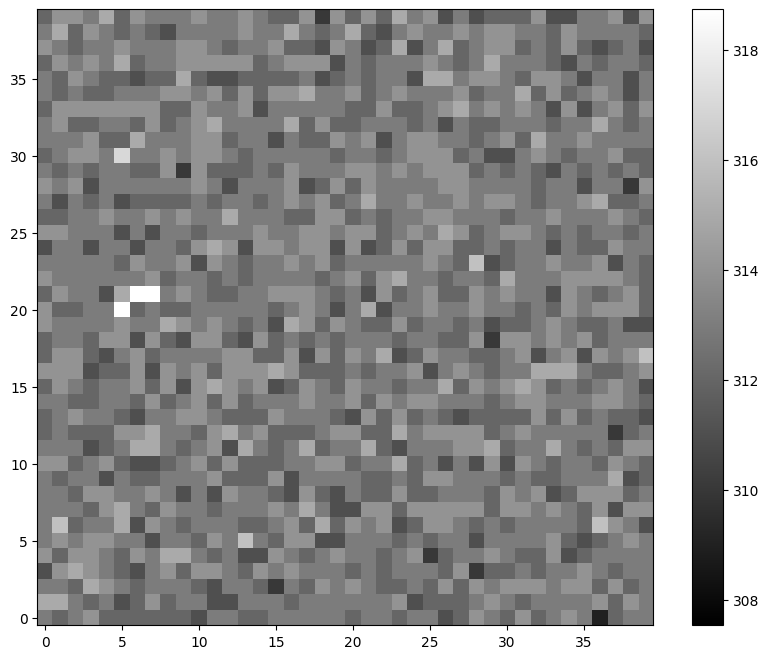

In [14]:
# Read the FITS image into a 2D numpy array
fits_image_filename = fitsio.util.get_testdata_filepath('test0.fits')

hdul = fitsio.open(fits_image_filename)
data = hdul[1].data

# Converting big edian to little edian (native byte order)
data = data.byteswap().newbyteorder()

# Calculate mean and standard deviation of the data for scaling
m, s = np.mean(data), np.std(data)

# Display the image with proper scaling
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig("1.png")

## Background subtraction

In [15]:
# Convert the data to native byte order and to float32
data = data.astype(data.dtype.newbyteorder('=')).astype(np.float32)

# Estimate a spatially varying background on the image
bkg = sep.Background(data)

313.1113586425781
0.9565773606300354


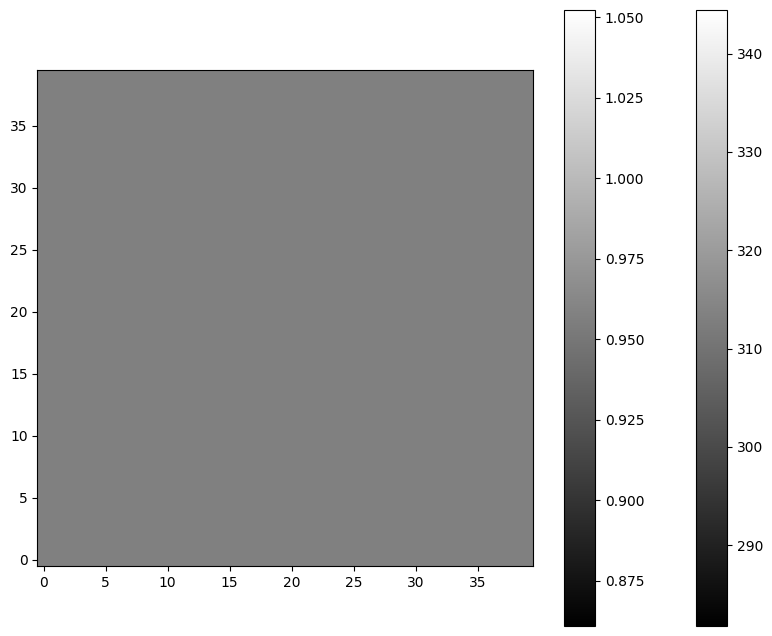

In [16]:
# Get global background and noise values
print(bkg.globalback)
print(bkg.globalrms)

# Retrieve the background as a 2D array (same dimensions as the image)
bkg_image = bkg.back()

# Display the background image
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

# Retrieve the background noise as a 2D array
bkg_rms = bkg.rms()

# Display the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("2.png")

# Subtract the background from the original image
data_sub = data - bkg


## Object Detection

In [17]:
# Extract objects from the background-subtracted image
# The threshold is set to 1.5 times the global background RMS.
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [18]:
print(len(objects))  # Should output the number of detected objects

1


## Visualizing Detected Objects

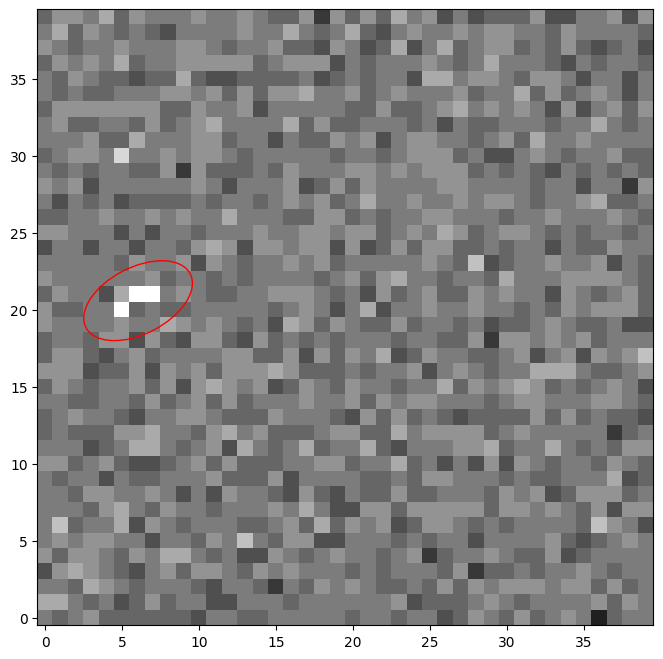

In [19]:
from matplotlib.patches import Ellipse

# Create a plot of the background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# Overlay ellipses on the detected objects
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig("3.png")


In [20]:
print(objects.dtype.names)

('thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y', 'x2', 'y2', 'xy', 'errx2', 'erry2', 'errxy', 'a', 'b', 'theta', 'cxx', 'cyy', 'cxy', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak', 'xpeak', 'ypeak', 'flag')


## Aperture Photometry

In [21]:
# Perform circular aperture photometry with a radius of 3 pixels
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0,
                                     err=bkg.globalrms, gain=1.0)

print("Number of objects:", len(flux))

# Display photometry results for the first 10 objects
for i in range(len(flux)):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

Number of objects: 1
object 0: flux = 342.539686 +/- 19.192285
